In [192]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns
import neal
import re

In [4]:
def drawCommunities(G, partition, pos):
    # G is graph in networkx form
    # Partition is a dict containing info on clusters
    # Pos is base on networkx spring layout (nx.spring_layout(G))

    # For separating communities colors
    dictList = defaultdict(list)
    nodelist = []
    for node, com in partition.items():
        dictList[com].append(node)

    # Get size of Communities
    size = len(set(partition.values()))

    # For loop to assign communities colors
    for i in range(size):

        amplifier = i % 3
        multi = (i / 3) * 0.3

        red = green = blue = 0

        if amplifier == 0:
            red = 0.1 + multi
        elif amplifier == 1:
            green = 0.1 + multi
        else:
            blue = 0.1 + multi
        # Draw Nodes
        nx.draw_networkx_nodes(G, pos,
                               nodelist=dictList[i],
                               node_color=[0.0 + red, 0.0 + 
                                           green, 0.0 + blue],
                               node_size=500,
                               alpha=0.8)

    # Draw edges and final plot
    plt.title("Random Graph")
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=16, font_color='w')

In [5]:
path = 'C:/Users/Fai Huntrakool/Downloads/country.csv'

In [6]:
df = pd.read_csv(path)

In [7]:
n = 10
cluster_size = 2

In [8]:
us = df[(df['Country']=='us') & (df['Region']=='CA')].sample(frac=1).reset_index(drop=True)[:n]
us['Adj_Long'] = (us['Longitude']-us['Longitude'].mean())*10
us['Adj_Lat'] = (us['Latitude']-us['Latitude'].mean())*10

In [9]:
us

,Country,City,AccentCity,Region,Population,Latitude,Longitude,Adj_Long,Adj_Lat
0,us,blue lake junction,Blue Lake Junction,CA,NaN,38.258611,-120.330556,-4.155000,16.448611
1,us,canyon country,Canyon Country,CA,NaN,34.423333,-118.471111,14.439445,-21.904167
2,us,annette,Annette,CA,NaN,35.650833,-120.178056,-2.630000,-9.629167
3,us,panorama city,Panorama City,CA,NaN,34.224722,-118.448889,14.661667,-23.890278
4,us,thunderbird ranches,Thunderbird Ranches,CA,NaN,34.522778,-117.119722,27.953334,-20.909722
5,us,gualala,Gualala,CA,NaN,38.765833,-123.526944,-36.118888,21.520833
6,us,dozier,Dozier,CA,NaN,38.285556,-121.815556,-19.005000,16.718056
7,us,mile high,Mile High,CA,NaN,34.412778,-117.773056,21.420000,-22.009722
8,us,cougar,Cougar,CA,NaN,41.583333,-122.184167,-22.691111,49.695833
9,us,quail,Quail,CA,NaN,36.009722,-119.302500,6.125556,-6.040278


In [10]:
df1 = us.loc[:,['Adj_Long','Adj_Lat']]

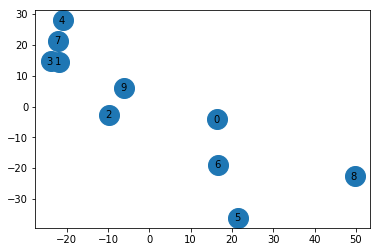

In [11]:
fig, ax = plt.subplots()
ax.scatter(x="Adj_Lat", y="Adj_Long", data=df1, s=400)
for line in range(0,df1.shape[0]):
     ax.annotate(line, (df1['Adj_Lat'][line]-1, df1['Adj_Long'][line]-1))
    

In [12]:
def dist(x1,y1,x2,y2):
    return np.round(np.sqrt((x1-x2)**2+(y1-y2)**2))

In [13]:
kmeans = KMeans(n_clusters=cluster_size, n_init=200)
kmeans.fit(df1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=200, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [14]:
labels = kmeans.predict(df1)

In [15]:
df1['cluster'] = labels

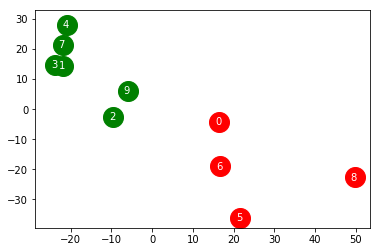

In [16]:
colmap = {0: 'r', 1: 'g', 2: 'b'}

fig, ax = plt.subplots()
for i in list(range(0,cluster_size)):
    ax.scatter(x="Adj_Lat", y="Adj_Long", data=df1[df1["cluster"]==i], s=400, color = colmap[i])
for line in range(0,df1.shape[0]):
     ax.annotate(line, (df1['Adj_Lat'][line]-1, df1['Adj_Long'][line]-1), color = "w")

In [17]:
cl = list(range(0,cluster_size))
cl 

[0, 1]

### Shortest Path

In [377]:
c = 1
use = df1[df1['cluster'] == c]

In [378]:
from collections import defaultdict
modify_node = defaultdict(int)
for index,u in zip(range(len(use)) ,use.index):
    modify_node[index] = u

In [379]:
modify_node

defaultdict(int, {0: 1, 1: 2, 2: 3, 3: 4, 4: 7, 5: 9})

In [380]:
G = nx.complete_graph(len(use))

In [381]:
for (u, v) in G.edges():
    x1,y1 = use.loc[modify_node[u],["Adj_Lat","Adj_Long"]]
    x2,y2 = use.loc[modify_node[v],["Adj_Lat","Adj_Long"]]
    G.edges[u,v]['weight'] = dist(x1,y1,x2,y2)

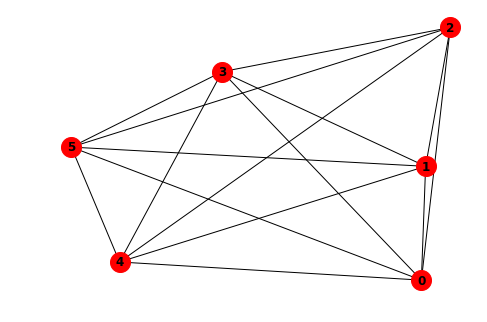

In [382]:
nx.draw(G, node_size=400, node_color='red', with_labels=True, font_weight='bold')
plt.show()

In [383]:
DistMat = nx.adjacency_matrix(G).todense()
DistMat

matrix([[ 0., 21.,  2., 14.,  7., 18.],
        [21.,  0., 22., 33., 27.,  9.],
        [ 2., 22.,  0., 14.,  7., 20.],
        [14., 33., 14.,  0.,  7., 26.],
        [ 7., 27.,  7.,  7.,  0., 22.],
        [18.,  9., 20., 26., 22.,  0.]])

### Travel Salemans Problem

In [384]:
from pyqubo import Array

In [437]:
size = (len(DistMat),len(DistMat))
x = Array.create('x', size, "BINARY")

### Objective Function 
$H_A=A\sum_{i=1}^n(1-\sum_{j=1}^nx_{i,j})^2+A\sum_{j=1}^n(1-\sum_{i=1}^nx_{i,j})^2$ <br>
$H_B=B\sum_{ui\in E}^nD_{ui}(\sum_{j=1}x_{u,j}x_{i,j+1})$ <br>
<br>
min $H = H_A+H_B$




In [386]:
HA_1 = 0
HA_2 = 0
for i in range(len(DistMat)):
    temp_1 = 1
    temp_2 = 1
    for j in range(len(DistMat)):
        if i!=j:
            temp_1 -= x[i][j]
            temp_2 -= x[j][i]
    HA_1 += temp_1**2
    HA_2 += temp_2**2

In [387]:
HB = 0
for u,i in list(G.edges):
    temp = 0
    for j in range(0,len(DistMat)-1):
        temp += x[u][j]*x[i][j+1] + x[i][j]*x[u][j+1] 
    HB += DistMat.item((u, i))*temp

In [412]:
max_distance = DistMat.max()
B = 1
A = max_distance*10

In [413]:
H = A*(HA_1 + HA_2) + B*HB

In [414]:
model = H.compile()
bqm = model.to_dimod_bqm()

In [415]:
def sa_solver(bqm):
    sampler = neal.SimulatedAnnealingSampler()
    response = sampler.sample(bqm, num_reads=100)
    min_energy = float("inf")
    current_solution = []
    for sample, energy in response.data(['sample', 'energy']):
        if energy < min_energy:
            current_solution = sample
    return current_solution

In [438]:
def display_mat(current_solution, DistMat, modify_node):
    ans_mat = np.zeros((len(DistMat),len(DistMat)))
    for key,val in current_solution.items():
        temp = re.findall(r'\d+', key) 
        x,y = list(map(int, temp))
        ans_mat[x,y] = val
        ans_mat[y,x] = val
    print(ans_mat)
    route = list(np.argmax(ans_mat, axis=0))
    route.append(route[0])
    route = [modify_node[i] for i in route]
    edges = []
    for x in range(len(route)-1):
        edges.append((route[x],route[x+1]))
    G = nx.Graph()
    G.add_edges_from(edges)
    nx.draw_circular(G, node_size=400, node_color='red', with_labels=True, font_weight='bold')
    plt.show()
    return route

[[0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]]


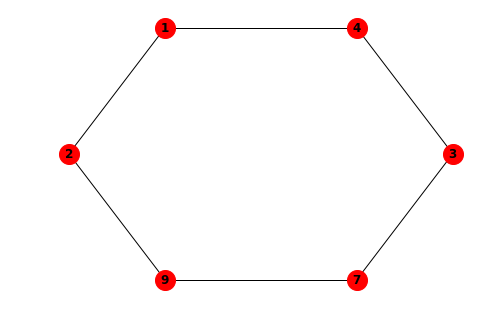

[3, 4, 1, 2, 9, 7, 3]

In [443]:
current_solution = sa_solver(bqm)
display_mat(current_solution, DistMat, modify_node)

In [431]:
def shortest_path(df1, c):
    use = df1[df1['cluster'] == c]
    from collections import defaultdict
    modify_node = defaultdict(int)
    for index,u in zip(range(len(use)) ,use.index):
        modify_node[index] = u
    G = nx.complete_graph(len(use))
    for (u, v) in G.edges():
        x1,y1 = use.loc[modify_node[u],["Adj_Lat","Adj_Long"]]
        x2,y2 = use.loc[modify_node[v],["Adj_Lat","Adj_Long"]]
        G.edges[u,v]['weight'] = dist(x1,y1,x2,y2)
   # nx.draw(G, node_size=400, node_color='red', with_labels=True, font_weight='bold')
    #plt.show()
    DistMat = nx.adjacency_matrix(G).todense()
    size = (len(DistMat),len(DistMat))
    x = Array.create('x', size, "BINARY")
    HA_1 = 0
    HA_2 = 0
    for i in range(len(DistMat)):
        temp_1 = 1
        temp_2 = 1
        for j in range(len(DistMat)):
            if i!=j:
                temp_1 -= x[i][j]
                temp_2 -= x[j][i]
        HA_1 += temp_1**2
        HA_2 += temp_2**2
    HB = 0
    for u,i in list(G.edges):
        temp = 0
        for j in range(0,len(DistMat)-1):
            temp += x[u][j]*x[i][j+1] + x[i][j]*x[u][j+1] 
        HB += DistMat.item((u, i))*temp
    max_distance = DistMat.max()
    B = 1
    A = max_distance*(len(DistMat))
    H = A*(HA_1 + HA_2) + B*HB
    model = H.compile()
    bqm = model.to_dimod_bqm()
    current_solution = sa_solver(bqm)
    route = display_mat(current_solution, DistMat, modify_node)
    print(route)

0


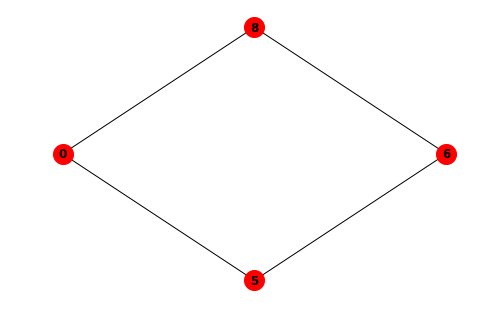

[6, 8, 0, 5, 6]
1


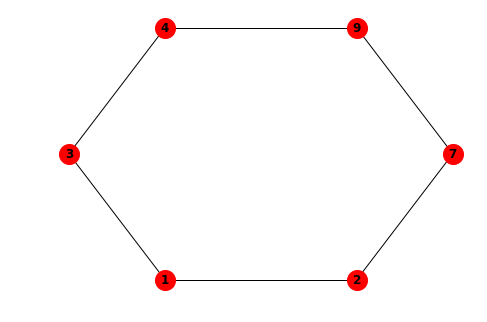

[7, 9, 4, 3, 1, 2, 7]


In [436]:
for c in cl:
    print(c)
    shortest_path(df1, c)